In [ ]:
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import time
import os
from IPython import display
from google.colab import drive
drive.mount('/content/drive')
train_x = loadmat('/content/drive/MyDrive/train_32x32.mat')['X']

In [ ]:
#We need to get the number of images as the first dimension
train_x=train_x.transpose((3,0,1,2))
train_x.shape

(73257, 32, 32, 3)

In [ ]:
#we will convert our images from RGB to Grayscale to reduces the amount of data
#for greyscale
train_x = tf.image.rgb_to_grayscale(tf.convert_to_tensor(train_x)).numpy().astype(np.float32)
train_x = (train_x - 127.5) / 127.5 
train_x = tf.data.Dataset.from_tensor_slices(train_x).shuffle(50000).batch(512)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4,beta_1 = 0.5)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images, generator, discriminator):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if (epoch==1) or (epoch%10==0):
    plt.savefig('/content/drive/MyDrive/'+model_+'_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs, generator, discriminator):

  for epoch in range(epochs):
    start = time.time()
    loss_train = []
    for image_batch in dataset:
      loss_train.append(train_step(image_batch, generator, discriminator))

    train_loss.loc[len(train_loss)] = np.mean(loss_train, axis=0)
    # tensorboard
    with gen_summary_writer.as_default():
        tf.summary.scalar('generator_loss', train_loss.gen_loss.values[-1], step=epoch)
    with disc_summary_writer.as_default():
        tf.summary.scalar('discrinimator_loss', train_loss.disc_loss.values[-1], step=epoch)
    # Produce images for the GIF as we go
    if (epoch==1) or (epoch%10==0):
        generate_and_save_images(generator,epoch,seed)
    print('Time for epoch {} is {} sec, generation loss: {}, discrimination loss: {}'.format(epoch + 1, time.time()-start, train_loss.gen_loss.values[-1], train_loss.disc_loss.values[-1]))

  generate_and_save_images(generator,epochs,seed)
  
  return 

In [ ]:
# from github - added function
def summary_writer(dir):
    return(tf.summary.create_file_writer(dir))

In [ ]:
%load_ext tensorboard

In [ ]:
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [ ]:
def make_generator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, use_bias=False, input_shape=(100,), activation='relu'))
    model.add(layers.Dense(512, use_bias=False, activation='relu'))
    model.add(layers.Dense(4096, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Relu())
    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), use_bias=False))
    model.add(layers.Cropping2D(1))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyRelu())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), use_bias=False))
    model.add(layers.Cropping2D(1))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyRelu())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), use_bias=False, activation='tanh'))
    model.add(layers.Cropping2D(1))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [ ]:
def make_discriminator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(1, 1), padding='same', use_bias=False, input_shape=[32, 32, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))


    model.add(layers.Conv2D(128, (4, 4), strides=(1, 1),padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))


    model.add(layers.Conv2D(256, (4, 4), strides=(1, 1),use_bias=False,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))
 

    model.add(layers.Flatten())
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(64, use_bias=False))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(16, use_bias=False))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(1))

    return model

In [ ]:
generator_2 = make_generator_model_2()
discriminator_2 = make_discriminator_model_2()

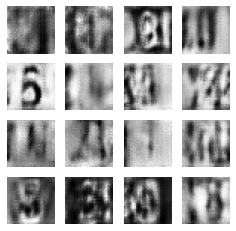

Time for epoch 1 is 39.35853981971741 sec, generation loss: 0.8587751984596252, discrimination loss: 1.6939283609390259


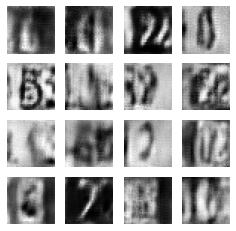

Time for epoch 2 is 32.577271699905396 sec, generation loss: 0.8159754872322083, discrimination loss: 1.8491770029067993
Time for epoch 3 is 32.28343224525452 sec, generation loss: 0.8436450362205505, discrimination loss: 1.7597383260726929
Time for epoch 4 is 32.58927249908447 sec, generation loss: 0.8608676195144653, discrimination loss: 1.7277263402938843
Time for epoch 5 is 32.87685203552246 sec, generation loss: 0.8684343099594116, discrimination loss: 1.7254102230072021
Time for epoch 6 is 33.16454577445984 sec, generation loss: 0.8657504320144653, discrimination loss: 1.7238106727600098
Time for epoch 7 is 33.375322103500366 sec, generation loss: 0.8659676313400269, discrimination loss: 1.738370418548584
Time for epoch 8 is 33.55873465538025 sec, generation loss: 0.8559296131134033, discrimination loss: 1.7530286312103271
Time for epoch 9 is 33.64839220046997 sec, generation loss: 0.8650942444801331, discrimination loss: 1.7608022689819336
Time for epoch 10 is 33.760653257369995

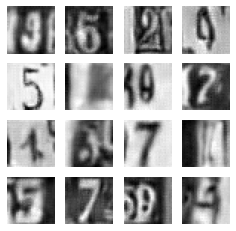

Time for epoch 11 is 34.34290313720703 sec, generation loss: 0.8567935228347778, discrimination loss: 1.7732348442077637
Time for epoch 12 is 33.75051474571228 sec, generation loss: 0.8674384355545044, discrimination loss: 1.7719414234161377
Time for epoch 13 is 33.74511170387268 sec, generation loss: 0.8638466596603394, discrimination loss: 1.7544549703598022
Time for epoch 14 is 33.721031665802 sec, generation loss: 0.8625127673149109, discrimination loss: 1.7677361965179443
Time for epoch 15 is 33.76561617851257 sec, generation loss: 0.8638864755630493, discrimination loss: 1.7710984945297241
Time for epoch 16 is 33.779465675354004 sec, generation loss: 0.8613879084587097, discrimination loss: 1.7918988466262817
Time for epoch 17 is 33.784812688827515 sec, generation loss: 0.86406010389328, discrimination loss: 1.7851876020431519
Time for epoch 18 is 33.79401898384094 sec, generation loss: 0.8663111925125122, discrimination loss: 1.7905914783477783
Time for epoch 19 is 33.7615110874

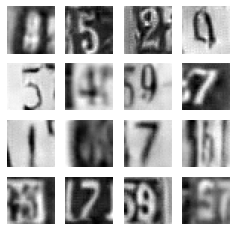

Time for epoch 21 is 34.22479963302612 sec, generation loss: 0.8621079921722412, discrimination loss: 1.7963050603866577
Time for epoch 22 is 33.81689476966858 sec, generation loss: 0.8561384081840515, discrimination loss: 1.8200637102127075
Time for epoch 23 is 33.817211627960205 sec, generation loss: 0.8638717532157898, discrimination loss: 1.8114317655563354
Time for epoch 24 is 33.66802978515625 sec, generation loss: 0.850917637348175, discrimination loss: 1.822952389717102
Time for epoch 25 is 33.65296745300293 sec, generation loss: 0.8454405665397644, discrimination loss: 1.844785451889038
Time for epoch 26 is 33.699538230895996 sec, generation loss: 0.8453826308250427, discrimination loss: 1.8543126583099365
Time for epoch 27 is 33.71658635139465 sec, generation loss: 0.8358901143074036, discrimination loss: 1.8738679885864258
Time for epoch 28 is 33.712037324905396 sec, generation loss: 0.835467517375946, discrimination loss: 1.8829078674316406
Time for epoch 29 is 33.732688188

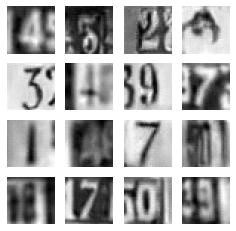

Time for epoch 31 is 34.24621057510376 sec, generation loss: 0.8127263188362122, discrimination loss: 1.9518085718154907
Time for epoch 32 is 33.79960536956787 sec, generation loss: 0.8102921843528748, discrimination loss: 1.9837076663970947
Time for epoch 33 is 33.8196382522583 sec, generation loss: 0.801045298576355, discrimination loss: 2.017407178878784
Time for epoch 34 is 33.774861335754395 sec, generation loss: 0.7987688183784485, discrimination loss: 2.01397967338562
Time for epoch 35 is 33.76315975189209 sec, generation loss: 0.7839576005935669, discrimination loss: 2.0453081130981445
Time for epoch 36 is 33.75186204910278 sec, generation loss: 0.7903693914413452, discrimination loss: 2.069908618927002
Time for epoch 37 is 33.726436614990234 sec, generation loss: 0.7761978507041931, discrimination loss: 2.106677532196045
Time for epoch 38 is 33.75358176231384 sec, generation loss: 0.7681131958961487, discrimination loss: 2.1314001083374023
Time for epoch 39 is 33.7756831645965

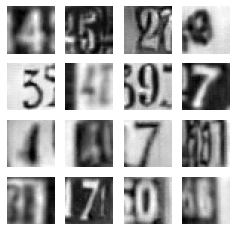

Time for epoch 41 is 34.30762791633606 sec, generation loss: 0.7503467798233032, discrimination loss: 2.206934928894043
Time for epoch 42 is 33.78508114814758 sec, generation loss: 0.7411195039749146, discrimination loss: 2.236360788345337
Time for epoch 43 is 33.82248640060425 sec, generation loss: 0.7417627573013306, discrimination loss: 2.2548248767852783
Time for epoch 44 is 33.76938247680664 sec, generation loss: 0.7290560603141785, discrimination loss: 2.2902438640594482
Time for epoch 45 is 33.78039216995239 sec, generation loss: 0.727278470993042, discrimination loss: 2.303257465362549
Time for epoch 46 is 33.756417751312256 sec, generation loss: 0.7196415662765503, discrimination loss: 2.3510804176330566
Time for epoch 47 is 33.811643838882446 sec, generation loss: 0.7056224346160889, discrimination loss: 2.375627040863037
Time for epoch 48 is 33.76560640335083 sec, generation loss: 0.7022010684013367, discrimination loss: 2.4268736839294434
Time for epoch 49 is 33.73901629447

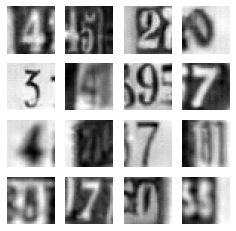

Time for epoch 51 is 34.27180075645447 sec, generation loss: 0.6865772604942322, discrimination loss: 2.479975461959839
Time for epoch 52 is 33.674795627593994 sec, generation loss: 0.6773004531860352, discrimination loss: 2.5242297649383545
Time for epoch 53 is 33.703975677490234 sec, generation loss: 0.6774478554725647, discrimination loss: 2.545098304748535
Time for epoch 54 is 33.70443940162659 sec, generation loss: 0.6760740280151367, discrimination loss: 2.545144557952881
Time for epoch 55 is 33.798561811447144 sec, generation loss: 0.6643166542053223, discrimination loss: 2.5881543159484863
Time for epoch 56 is 33.81118583679199 sec, generation loss: 0.6589155197143555, discrimination loss: 2.6362836360931396
Time for epoch 57 is 33.796292781829834 sec, generation loss: 0.6521605849266052, discrimination loss: 2.6621358394622803
Time for epoch 58 is 33.79954481124878 sec, generation loss: 0.6457740068435669, discrimination loss: 2.7011430263519287
Time for epoch 59 is 33.7546935

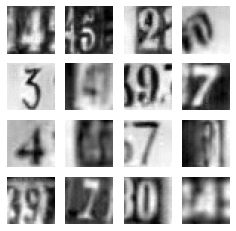

Time for epoch 61 is 34.249375104904175 sec, generation loss: 0.6334831118583679, discrimination loss: 2.7520627975463867
Time for epoch 62 is 33.810253381729126 sec, generation loss: 0.6309143900871277, discrimination loss: 2.776357412338257
Time for epoch 63 is 33.78581690788269 sec, generation loss: 0.6215084195137024, discrimination loss: 2.8110430240631104
Time for epoch 64 is 33.764134883880615 sec, generation loss: 0.6202792525291443, discrimination loss: 2.832085132598877
Time for epoch 65 is 33.634984493255615 sec, generation loss: 0.6136280298233032, discrimination loss: 2.875746250152588
Time for epoch 66 is 33.62166476249695 sec, generation loss: 0.611566960811615, discrimination loss: 2.8716678619384766
Time for epoch 67 is 33.69877862930298 sec, generation loss: 0.6072168350219727, discrimination loss: 2.9094579219818115
Time for epoch 68 is 33.75616097450256 sec, generation loss: 0.5994322896003723, discrimination loss: 2.9443933963775635
Time for epoch 69 is 33.71216845

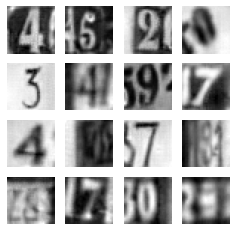

Time for epoch 71 is 34.072351932525635 sec, generation loss: 0.5887776613235474, discrimination loss: 3.0318524837493896
Time for epoch 72 is 33.62729215621948 sec, generation loss: 0.5830388069152832, discrimination loss: 3.0458571910858154
Time for epoch 73 is 33.682992458343506 sec, generation loss: 0.5771878361701965, discrimination loss: 3.08502197265625
Time for epoch 74 is 33.722033977508545 sec, generation loss: 0.5743531584739685, discrimination loss: 3.099259614944458
Time for epoch 75 is 33.72029447555542 sec, generation loss: 0.5728034377098083, discrimination loss: 3.114840030670166
Time for epoch 76 is 33.73786783218384 sec, generation loss: 0.5688474774360657, discrimination loss: 3.1557202339172363
Time for epoch 77 is 33.741363525390625 sec, generation loss: 0.5549443364143372, discrimination loss: 3.1815505027770996
Time for epoch 78 is 33.68996000289917 sec, generation loss: 0.5522744655609131, discrimination loss: 3.24094820022583
Time for epoch 79 is 33.6612863540

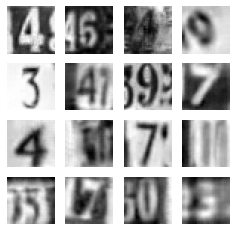

Time for epoch 81 is 34.21171736717224 sec, generation loss: 0.5493677258491516, discrimination loss: 3.2578282356262207
Time for epoch 82 is 33.69019865989685 sec, generation loss: 0.5435063242912292, discrimination loss: 3.303450107574463
Time for epoch 83 is 33.71934413909912 sec, generation loss: 0.5445376634597778, discrimination loss: 3.2878119945526123
Time for epoch 84 is 33.730705976486206 sec, generation loss: 0.5390711426734924, discrimination loss: 3.3259360790252686
Time for epoch 85 is 33.75656509399414 sec, generation loss: 0.5350170731544495, discrimination loss: 3.351339817047119
Time for epoch 86 is 33.70598530769348 sec, generation loss: 0.5297540426254272, discrimination loss: 3.388899803161621
Time for epoch 87 is 33.68963813781738 sec, generation loss: 0.5297633409500122, discrimination loss: 3.413224697113037
Time for epoch 88 is 33.70535659790039 sec, generation loss: 0.5266266465187073, discrimination loss: 3.4268062114715576
Time for epoch 89 is 33.72626042366

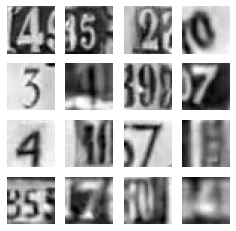

Time for epoch 91 is 34.31736612319946 sec, generation loss: 0.5063868761062622, discrimination loss: 3.5068252086639404
Time for epoch 92 is 33.75410008430481 sec, generation loss: 0.5212512612342834, discrimination loss: 3.4846715927124023
Time for epoch 93 is 33.7410991191864 sec, generation loss: 0.5163904428482056, discrimination loss: 3.4957871437072754
Time for epoch 94 is 33.715683460235596 sec, generation loss: 0.5023279786109924, discrimination loss: 3.547431230545044
Time for epoch 95 is 33.68806457519531 sec, generation loss: 0.5030113458633423, discrimination loss: 3.549222469329834
Time for epoch 96 is 33.697208642959595 sec, generation loss: 0.5020972490310669, discrimination loss: 3.547717332839966
Time for epoch 97 is 33.63669204711914 sec, generation loss: 0.5050885081291199, discrimination loss: 3.5920143127441406
Time for epoch 98 is 33.66824913024902 sec, generation loss: 0.49805572628974915, discrimination loss: 3.5899741649627686
Time for epoch 99 is 33.741035461

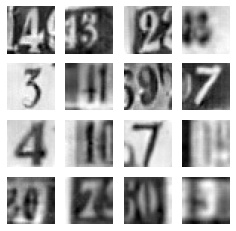

Time for epoch 101 is 34.21563386917114 sec, generation loss: 0.4894541800022125, discrimination loss: 3.6669628620147705
Time for epoch 102 is 33.68632912635803 sec, generation loss: 0.48315057158470154, discrimination loss: 3.707345962524414
Time for epoch 103 is 33.6832172870636 sec, generation loss: 0.4876914322376251, discrimination loss: 3.713273525238037
Time for epoch 104 is 33.76518630981445 sec, generation loss: 0.476659893989563, discrimination loss: 3.7328381538391113
Time for epoch 105 is 33.713130235672 sec, generation loss: 0.467543363571167, discrimination loss: 3.7958691120147705
Time for epoch 106 is 33.71845602989197 sec, generation loss: 0.47163039445877075, discrimination loss: 3.8366811275482178
Time for epoch 107 is 33.70464468002319 sec, generation loss: 0.46408355236053467, discrimination loss: 3.84025239944458
Time for epoch 108 is 33.70409059524536 sec, generation loss: 0.4689673185348511, discrimination loss: 3.8333821296691895
Time for epoch 109 is 33.63421

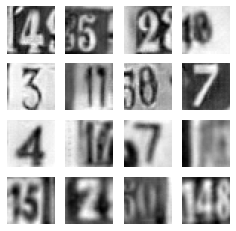

Time for epoch 111 is 34.0844190120697 sec, generation loss: 0.4614463448524475, discrimination loss: 3.8902604579925537
Time for epoch 112 is 33.66834497451782 sec, generation loss: 0.4617581367492676, discrimination loss: 3.8760852813720703
Time for epoch 113 is 33.61661171913147 sec, generation loss: 0.4570404291152954, discrimination loss: 3.907902479171753
Time for epoch 114 is 33.64417505264282 sec, generation loss: 0.4495008587837219, discrimination loss: 3.9670250415802
Time for epoch 115 is 33.64091920852661 sec, generation loss: 0.45646414160728455, discrimination loss: 3.9502007961273193
Time for epoch 116 is 33.671653270721436 sec, generation loss: 0.4485085606575012, discrimination loss: 3.977710485458374
Time for epoch 117 is 33.69685125350952 sec, generation loss: 0.45007938146591187, discrimination loss: 4.001864910125732
Time for epoch 118 is 33.75707411766052 sec, generation loss: 0.4473103880882263, discrimination loss: 4.008488178253174
Time for epoch 119 is 33.6657

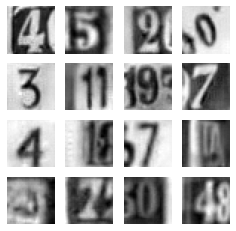

Time for epoch 121 is 34.238168716430664 sec, generation loss: 0.4425395429134369, discrimination loss: 4.056059837341309
Time for epoch 122 is 33.71299600601196 sec, generation loss: 0.4304814338684082, discrimination loss: 4.0845746994018555
Time for epoch 123 is 33.66694688796997 sec, generation loss: 0.4292364716529846, discrimination loss: 4.152604103088379
Time for epoch 124 is 33.71918249130249 sec, generation loss: 0.4278893768787384, discrimination loss: 4.153625011444092
Time for epoch 125 is 33.693880558013916 sec, generation loss: 0.43265560269355774, discrimination loss: 4.117496490478516
Time for epoch 126 is 33.712762117385864 sec, generation loss: 0.42860886454582214, discrimination loss: 4.131782054901123
Time for epoch 127 is 33.65782642364502 sec, generation loss: 0.4307159185409546, discrimination loss: 4.169783115386963
Time for epoch 128 is 33.69458293914795 sec, generation loss: 0.4262625277042389, discrimination loss: 4.198436260223389
Time for epoch 129 is 33.6

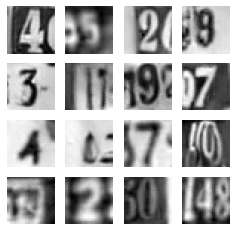

Time for epoch 131 is 34.28830575942993 sec, generation loss: 0.42050519585609436, discrimination loss: 4.221555233001709
Time for epoch 132 is 33.74196696281433 sec, generation loss: 0.4167320132255554, discrimination loss: 4.244961738586426
Time for epoch 133 is 33.74394965171814 sec, generation loss: 0.41210341453552246, discrimination loss: 4.260931491851807
Time for epoch 134 is 33.716636657714844 sec, generation loss: 0.4169963002204895, discrimination loss: 4.278601169586182
Time for epoch 135 is 33.70693302154541 sec, generation loss: 0.4047527611255646, discrimination loss: 4.323015213012695
Time for epoch 136 is 33.696061849594116 sec, generation loss: 0.4153252840042114, discrimination loss: 4.309780597686768
Time for epoch 137 is 33.69538950920105 sec, generation loss: 0.41432228684425354, discrimination loss: 4.267538070678711
Time for epoch 138 is 33.6628532409668 sec, generation loss: 0.40265220403671265, discrimination loss: 4.352819442749023
Time for epoch 139 is 33.72

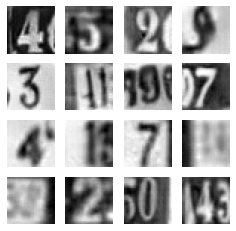

Time for epoch 141 is 34.240599155426025 sec, generation loss: 0.40134942531585693, discrimination loss: 4.436958312988281
Time for epoch 142 is 33.76576471328735 sec, generation loss: 0.39203503727912903, discrimination loss: 4.416083812713623
Time for epoch 143 is 33.729615926742554 sec, generation loss: 0.39886289834976196, discrimination loss: 4.402772903442383
Time for epoch 144 is 33.75612831115723 sec, generation loss: 0.3928038775920868, discrimination loss: 4.4788947105407715
Time for epoch 145 is 33.681522369384766 sec, generation loss: 0.39427876472473145, discrimination loss: 4.457064628601074
Time for epoch 146 is 33.730377435684204 sec, generation loss: 0.39030611515045166, discrimination loss: 4.46238374710083
Time for epoch 147 is 33.73151874542236 sec, generation loss: 0.39245158433914185, discrimination loss: 4.467835426330566
Time for epoch 148 is 33.74880599975586 sec, generation loss: 0.3887123167514801, discrimination loss: 4.490644931793213
Time for epoch 149 is 

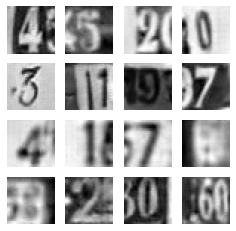

Time for epoch 151 is 34.10907459259033 sec, generation loss: 0.37657642364501953, discrimination loss: 4.559932708740234
Time for epoch 152 is 33.68672466278076 sec, generation loss: 0.3801632821559906, discrimination loss: 4.596620559692383
Time for epoch 153 is 33.744128465652466 sec, generation loss: 0.37820300459861755, discrimination loss: 4.618406295776367
Time for epoch 154 is 33.75166630744934 sec, generation loss: 0.375699907541275, discrimination loss: 4.611053943634033
Time for epoch 155 is 33.7680287361145 sec, generation loss: 0.37833401560783386, discrimination loss: 4.607064723968506
Time for epoch 156 is 33.716064453125 sec, generation loss: 0.371707022190094, discrimination loss: 4.6645121574401855
Time for epoch 157 is 33.70001196861267 sec, generation loss: 0.37576547265052795, discrimination loss: 4.630182266235352
Time for epoch 158 is 33.664918184280396 sec, generation loss: 0.36765187978744507, discrimination loss: 4.6278181076049805
Time for epoch 159 is 33.707

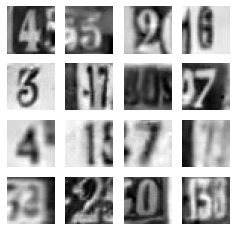

Time for epoch 161 is 34.24907064437866 sec, generation loss: 0.3717290163040161, discrimination loss: 4.669015884399414
Time for epoch 162 is 33.64495062828064 sec, generation loss: 0.36754027009010315, discrimination loss: 4.710659503936768
Time for epoch 163 is 33.68870711326599 sec, generation loss: 0.36897993087768555, discrimination loss: 4.694826602935791
Time for epoch 164 is 33.729641914367676 sec, generation loss: 0.35899752378463745, discrimination loss: 4.700231552124023
Time for epoch 165 is 33.763296604156494 sec, generation loss: 0.361276775598526, discrimination loss: 4.767137050628662
Time for epoch 166 is 33.684202909469604 sec, generation loss: 0.3582095503807068, discrimination loss: 4.749714374542236
Time for epoch 167 is 33.693939447402954 sec, generation loss: 0.3522546887397766, discrimination loss: 4.796237468719482
Time for epoch 168 is 33.6342089176178 sec, generation loss: 0.3571273684501648, discrimination loss: 4.782650470733643
Time for epoch 169 is 33.70

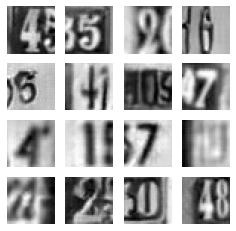

Time for epoch 171 is 34.313008546829224 sec, generation loss: 0.35964715480804443, discrimination loss: 4.845592021942139
Time for epoch 172 is 33.705092668533325 sec, generation loss: 0.34610432386398315, discrimination loss: 4.876692295074463
Time for epoch 173 is 33.75787401199341 sec, generation loss: 0.3563095033168793, discrimination loss: 4.815749168395996
Time for epoch 174 is 33.781288623809814 sec, generation loss: 0.35958144068717957, discrimination loss: 4.823884010314941
Time for epoch 175 is 33.66253900527954 sec, generation loss: 0.34545913338661194, discrimination loss: 4.857598304748535
Time for epoch 176 is 33.688873291015625 sec, generation loss: 0.34089648723602295, discrimination loss: 4.864343166351318
Time for epoch 177 is 33.77441120147705 sec, generation loss: 0.34799790382385254, discrimination loss: 4.894782066345215
Time for epoch 178 is 33.80601501464844 sec, generation loss: 0.3425593972206116, discrimination loss: 4.9459662437438965
Time for epoch 179 is

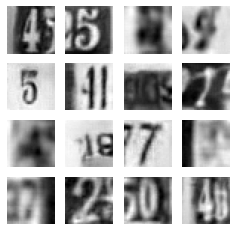

Time for epoch 181 is 34.18710207939148 sec, generation loss: 0.3404461145401001, discrimination loss: 4.941387176513672
Time for epoch 182 is 33.794376611709595 sec, generation loss: 0.3325137794017792, discrimination loss: 4.981282711029053
Time for epoch 183 is 33.76863408088684 sec, generation loss: 0.32990357279777527, discrimination loss: 4.9451398849487305
Time for epoch 184 is 33.71286106109619 sec, generation loss: 0.3307539224624634, discrimination loss: 5.029152870178223
Time for epoch 185 is 33.719544410705566 sec, generation loss: 0.33538204431533813, discrimination loss: 4.975888252258301
Time for epoch 186 is 33.67173457145691 sec, generation loss: 0.3217625916004181, discrimination loss: 5.083549976348877
Time for epoch 187 is 33.67132496833801 sec, generation loss: 0.3297373950481415, discrimination loss: 5.060110092163086
Time for epoch 188 is 33.76467990875244 sec, generation loss: 0.32334277033805847, discrimination loss: 5.037604808807373
Time for epoch 189 is 33.8

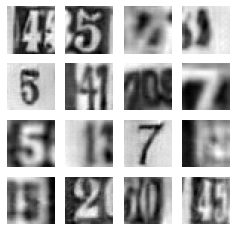

Time for epoch 191 is 34.1532347202301 sec, generation loss: 0.3273148238658905, discrimination loss: 5.108808517456055
Time for epoch 192 is 33.75736355781555 sec, generation loss: 0.3195168375968933, discrimination loss: 5.113055229187012
Time for epoch 193 is 33.78281116485596 sec, generation loss: 0.3241024315357208, discrimination loss: 5.122979640960693
Time for epoch 194 is 33.72090792655945 sec, generation loss: 0.32127684354782104, discrimination loss: 5.154830455780029
Time for epoch 195 is 33.75888419151306 sec, generation loss: 0.31708985567092896, discrimination loss: 5.170485019683838
Time for epoch 196 is 33.81155967712402 sec, generation loss: 0.31541165709495544, discrimination loss: 5.207077503204346
Time for epoch 197 is 33.68846774101257 sec, generation loss: 0.31770095229148865, discrimination loss: 5.200064182281494
Time for epoch 198 is 33.70274519920349 sec, generation loss: 0.31644144654273987, discrimination loss: 5.201488494873047
Time for epoch 199 is 33.687

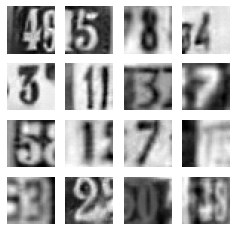

In [ ]:
gen_log_dir = 'logs/gradient_tape/GAN_gen_2'
disc_log_dir = 'logs/gradient_tape/GAN_disc_2'
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
model_='model_FCC'
train(train_x, 200, generator_2, discriminator_2)

In [ ]:
# generator_2.save('/content/drive/MyDrive/'+model_+'.h5')
# train_loss.to_csv('/content/drive/MyDrive/'+model_+'.csv')
# gen_log_dir = '/content/drive/MyDrive/gradient_tape/GAN_gen_2'
# disc_log_dir = '/content/drive/MyDrive/gradient_tape/GAN_disc_2'